In [64]:
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime 
from collections import defaultdict
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
from sklearn.cluster import DBSCAN
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [65]:
#create a pandas dataframes from csv files
users = pd.read_csv('new_users.csv', lineterminator='\n', index_col=0)
#tweets = pd.read_csv('new_tweets.csv', lineterminator='\n', index_col=0)
users.head(2)

user_id             name lang  bot  statuses_count  count  \
0  2353593986  Lamonica Raborn   en    1             132    132   
1  2358850842    Lourie Botton   en    0             122    122   

   retweet_received  reply_received  favorite_received  hashtag_used  ...  \
0                 5               0                  5            13  ...   
1                 3               0                  6             4  ...   

   tweets_per_year  activity_period  Bot_Entropy  sub_year  sub_month  \
0        22.000000                5     0.001426      2019          2   
1        20.333333                5          NaN      2019          2   

   sub_day  retweet_count_x  reply_count  favorite_count  retweet_count_y  
0       22              1.0          0.0             1.0                9  
1       26              1.0          0.0             1.0                9  

[2 rows x 29 columns]

In [66]:
users_clean = users.drop(columns= ['lang', 'name','user_id','Bot_Entropy'] , axis=1)
users_clean.head(5)

bot  statuses_count  count  retweet_received  reply_received  \
0    1             132    132                 5               0   
1    0             122    122                 3               0   
2    1            1439   1439              1190               0   
3    0            7085   3656                62               0   
4    0            7406   2081             31810               0   

   favorite_received  hashtag_used  urls_used  mentions_used  favorite_avg  \
0                  5            13          0             37          0.04   
1                  6             4          0             41          0.05   
2                259           107         36              9          0.18   
3                226           479          3           1936          0.06   
4               1260            54         60           1908          0.61   

   ...  avg_lenght  tweets_per_year  activity_period  sub_year  sub_month  \
0  ...          62        22.000000                5      2019          2   
1  ...          69        20.333333                5      2019          2   
2  ...          87       179.875000               30      2017          1   
3  ...          72       731.200000                4      2019          6   
4  ...          45       260.125000               19      2018         11   

   sub_day  retweet_count_x  reply_count  favorite_count  retweet_count_y  
0       22              1.0          0.0             1.0                9  
1       26              1.0          0.0             1.0                9  
2       18            364.0          0.0            11.0              238  
3       18              3.0          0.0             2.0              246  
4       19            390.0          0.0            12.0             1643  

[5 rows x 25 columns]

## Correlation Analysis

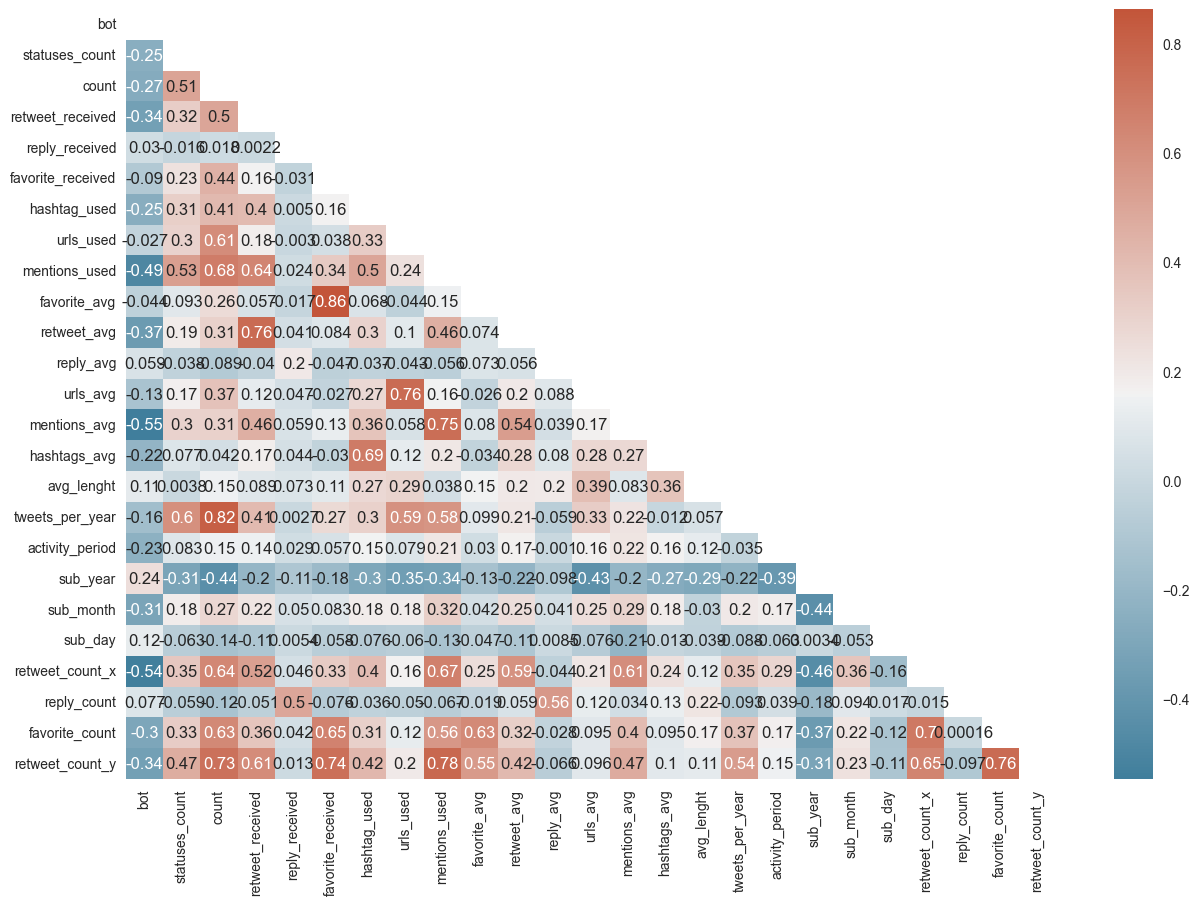

In [67]:
plt.figure(figsize=(15,10))

a = users_clean.corr()
mask = np.triu(np.ones_like(a, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(a, annot=True, mask = mask, cmap=cmap)

plt.show()

In [68]:
corr_threshold = 0.7
print("Att. A\t\t\tAtt. B\t\t\tCorr(A,B)")
for i in range(0, len(users_clean.columns)):
    for j in range(i+1, len(users_clean.columns)):
        corr = users_clean[users_clean.columns[i]].corr(users_clean[users_clean.columns[j]])
        if  corr > corr_threshold:
            print(users_clean.columns[i] + "\t\t\t" + users_clean.columns[j] + "\t\t\t" + '{:.4f}'.format(corr))

Att. A			Att. B			Corr(A,B)
count			tweets_per_year			0.8163
count			retweet_count_y			0.7310
retweet_received			retweet_avg			0.7584
favorite_received			favorite_avg			0.8628
favorite_received			retweet_count_y			0.7411
urls_used			urls_avg			0.7589
mentions_used			mentions_avg			0.7489
mentions_used			retweet_count_y			0.7781
retweet_count_x			favorite_count			0.7020
favorite_count			retweet_count_y			0.7603


In [69]:
dropping_column = ['sub_year', 'sub_day', 'sub_month', 'count', 'favorite_received', 'retweet_received', 'mentions_used', 'reply_received', 'hashtag_used', 'urls_used', 'bot']

# Kmeans

### Find best k with elbow method

In [70]:
users_clean.head()

bot  statuses_count  count  retweet_received  reply_received  \
0    1             132    132                 5               0   
1    0             122    122                 3               0   
2    1            1439   1439              1190               0   
3    0            7085   3656                62               0   
4    0            7406   2081             31810               0   

   favorite_received  hashtag_used  urls_used  mentions_used  favorite_avg  \
0                  5            13          0             37          0.04   
1                  6             4          0             41          0.05   
2                259           107         36              9          0.18   
3                226           479          3           1936          0.06   
4               1260            54         60           1908          0.61   

   ...  avg_lenght  tweets_per_year  activity_period  sub_year  sub_month  \
0  ...          62        22.000000                5      2019          2   
1  ...          69        20.333333                5      2019          2   
2  ...          87       179.875000               30      2017          1   
3  ...          72       731.200000                4      2019          6   
4  ...          45       260.125000               19      2018         11   

   sub_day  retweet_count_x  reply_count  favorite_count  retweet_count_y  
0       22              1.0          0.0             1.0                9  
1       26              1.0          0.0             1.0                9  
2       18            364.0          0.0            11.0              238  
3       18              3.0          0.0             2.0              246  
4       19            390.0          0.0            12.0             1643  

[5 rows x 25 columns]

In [71]:
# scaler = StandardScaler()
# #X = users_clean.drop(columns=['favorite_avg', 'retweet_avg', 'reply_avg', 'urls_avg', 'mentions_avg', 'hashtags_avg'])
# X = users_clean.drop(columns=dropping_column)
# X_scaler = scaler.fit_transform(X)

In [72]:
# distortions = []
# K = range(1,15)
# for k in K:
#     kmeanModel = KMeans(n_clusters=k)
#     kmeanModel.fit(X_scaler)
#     distortions.append(kmeanModel.inertia_)
# plt.figure(figsize=(9,4))
# plt.plot(K, distortions, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Distortion')
# plt.title('The Elbow Method showing the optimal k')
# plt.show()

In [73]:
users_clean = users_clean.drop(columns=dropping_column)

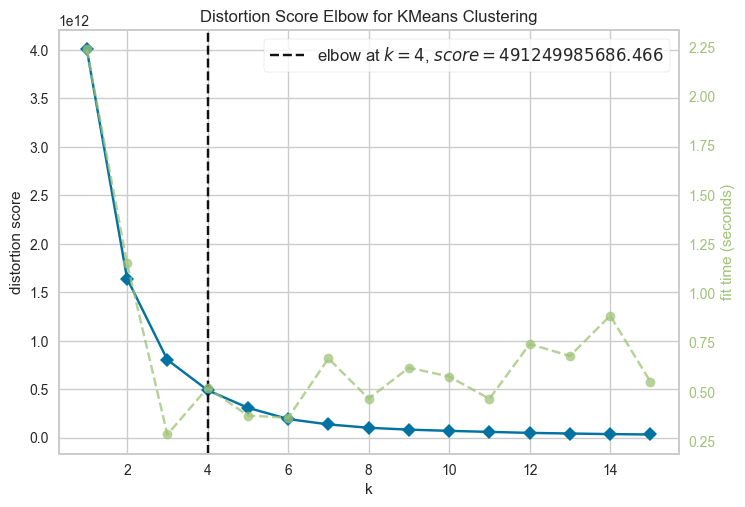

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [74]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,16), metric="distortion")

visualizer.fit(users_clean)        # Fit the data to the visualizer
visualizer.show()                  # Finalize and render the figure
# se ni mondo ci fosse meno clustering e la monri non facesse datamining 

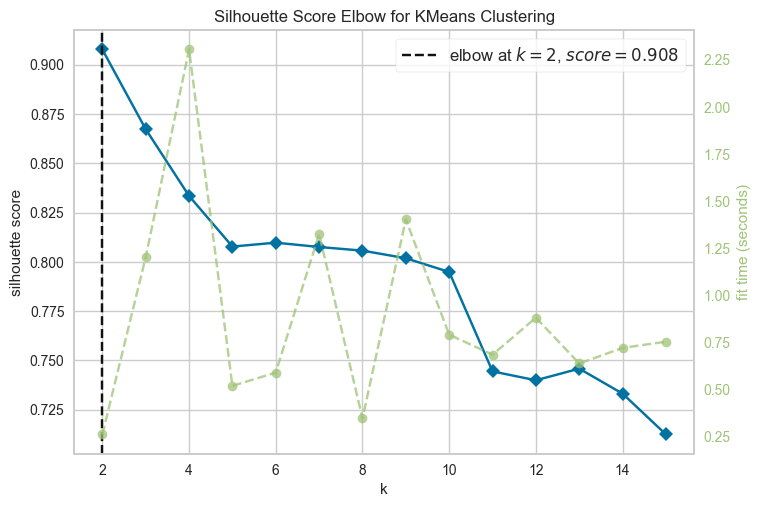

<AxesSubplot: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [75]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,16), metric="silhouette")

visualizer.fit(users_clean)        # Fit the data to the visualizer
visualizer.show() 

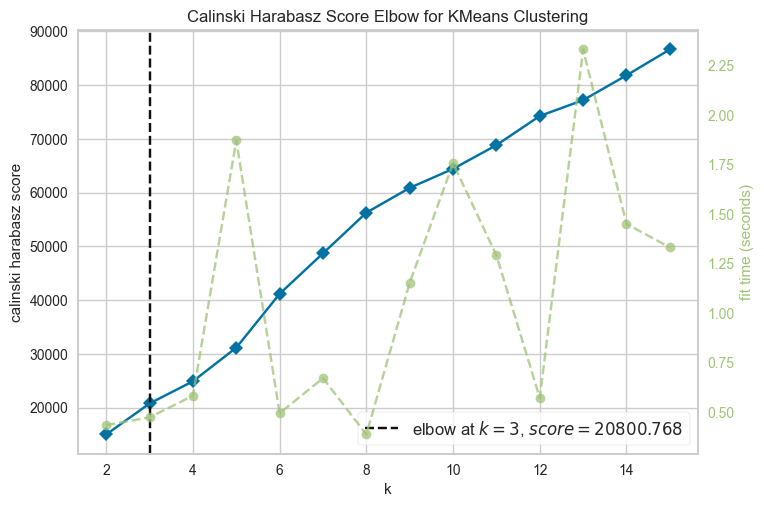

<AxesSubplot: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [76]:
# Instantiate the clustering model and visualizer with 
# ratio of within to between cluster dispersion (calinski_harabasz)

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,16), metric="calinski_harabasz")

visualizer.fit(users_clean)        # Fit the data to the visualizer
visualizer.show()   

In [77]:
clustering_numbers = 4

### Apply KMEANS

In [78]:
scaler = MinMaxScaler()
X = scaler.fit_transform(users_clean.values)

In [79]:
# calculate the cluster
kmeans = KMeans(clustering_numbers, n_init=10, max_iter=100)
kmeans.fit(X)

KMeans(max_iter=100, n_clusters=4)

In [80]:
# print the unique labels identified by K-Means
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3], dtype=int32), array([6008,  718, 1922, 1810]))

In [81]:
hist, bins = np.histogram(kmeans.labels_, bins=range(0, len(set(kmeans.labels_)) + 1))
dict(zip(bins, hist))

{0: 6008, 1: 718, 2: 1922, 3: 1810}

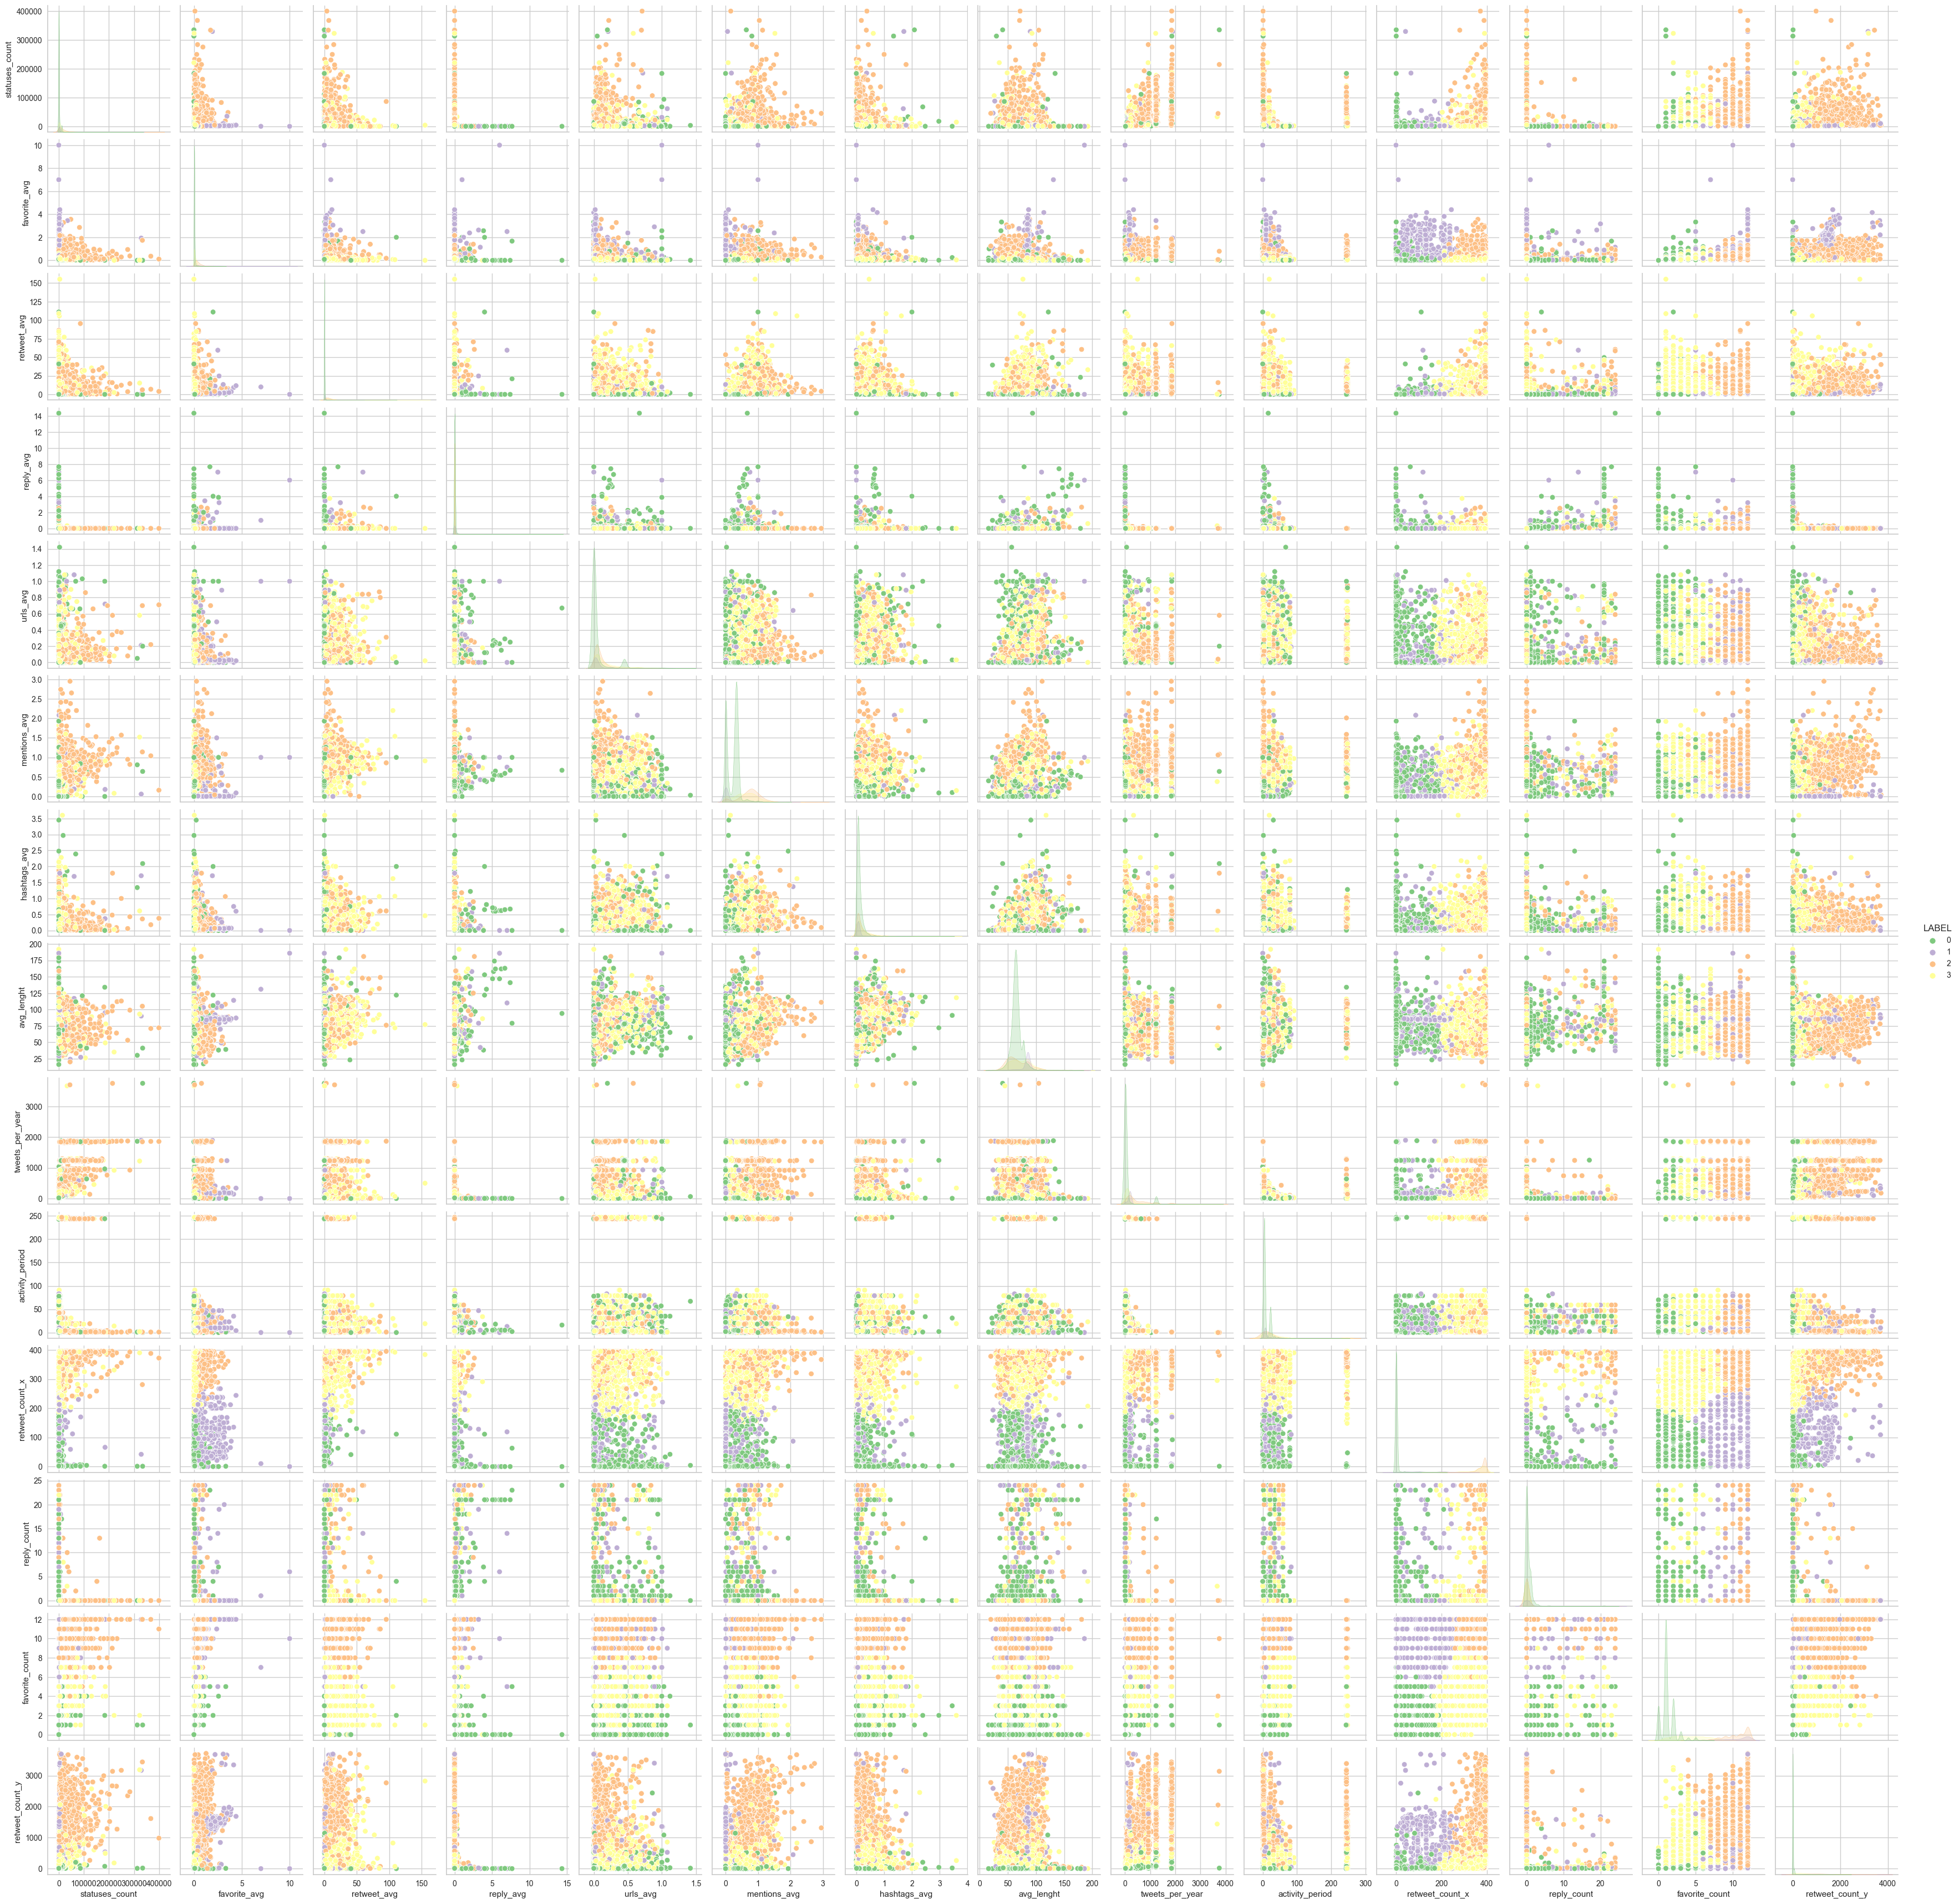

In [82]:
# Plot Clusters with Paiplot
cleaned_dataframe = users_clean.copy()
cleaned_dataframe["LABEL"] = kmeans.labels_
# Pairplot
sns.pairplot(data = cleaned_dataframe, hue = "LABEL", palette = "Accent")

### Old

In [83]:
centers = kmeanModel.cluster_centers_
centers = scaler.fit_transform(centers)

In [84]:
plt.figure(figsize = (10,5))
plt.scatter(X_scaler[:,0], X_scaler[:,12], c=kmeanModel.labels_, s=10)
plt.scatter(centers[:,0], centers[:,12],  c='red', marker='x', s=50)
plt.tick_params(labelsize=18)
plt.show()

IndexError: index 12 is out of bounds for axis 1 with size 10

<Figure size 1000x500 with 0 Axes>

# Hierarchical clustering

In [ ]:
data_dist = pdist(X_scaler, metric='euclidean')
data_link = linkage(data_dist, method='complete', metric='euclidean')
res = dendrogram(data_link, color_threshold=10, truncate_mode='lastp')

In [ ]:
data_dist = pdist(X_scaler, metric='euclidean')
data_link = linkage(data_dist, method='complete', metric='euclidean')
res = dendrogram(data_link, color_threshold=10, truncate_mode='lastp')

In [ ]:
data_dist = pdist(X_scaler, metric='euclidean')
data_link = linkage(data_dist, method='single', metric='euclidean')
res = dendrogram(data_link, color_threshold=0.75, truncate_mode='lastp')

In [ ]:
data_dist = pdist(X_scaler, metric='euclidean')
data_link = linkage(data_dist, method='average', metric='euclidean')
res = dendrogram(data_link, color_threshold=0.4, truncate_mode='lastp')

In [ ]:
#with sciki-learn you have to select the number of clusters you want
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
cluster.fit_predict(X_scaler)


In [ ]:
plt.scatter(X_scaler[:,0], X_scaler[:,1], c=cluster.labels_)

In [ ]:
plt.figure(figsize=(15,10))
data_dist = pdist(X_scaler, metric='euclidean')
data_link = linkage(data_dist, method='ward')

res = dendrogram(data_link, truncate_mode='lastp')

# Density clustering

In [ ]:
dbscan = DBSCAN(eps=0.15, min_samples=3)
dbscan.fit(X_scaler)

In [ ]:
dbscan.labels_[:5]

In [ ]:
np.unique(dbscan.labels_, return_counts=True)

In [ ]:
plt.scatter(users_clean['count'], users_clean['favorite_received'], c=dbscan.labels_, s=20)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

In [ ]:
print('Silhouette %s' % silhouette_score(X_scaler, dbscan.labels_))